# eThekwini Informal Settlement Segmentation Notebook

## 1. Imports and GPU Check

In [3]:
# Hide output of this cell
%%capture

# Install packages
!pip install fastcore fastai --upgrade
!pip3 install SemTorch

# Import packages
from fastai.vision.all import *
import pandas as pd
import numpy as np
import random
import os
import glob
import pytz
from datetime import datetime
from semtorch import get_segmentation_learner
from google.colab import drive
from IPython.display import Audio, display

In [4]:
# Check, which GPU was allocated 
!nvidia-smi

Tue Jan 25 09:26:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Set Parameters Define Required Functions

### 2.1. Loss Functions

In [5]:
# Create custom loss functions to evaluate
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

def flatten_binary_scores2(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_hinge(logits, labels, per_image=False, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    print(logits.min(), logits.max(), logits.size())
    logits=logits[:,1,:,:]
    labels = labels.squeeze(1)
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(torch.nn.functional.relu(errors_sorted), Variable(grad))
    return loss

def combined_loss(logits, labels):
    logits=logits[:,1,:,:].float()
    labels = labels.squeeze(1).float()
    
    lh_loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels, ignore=0))
    bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
    
    return 0.8 * bce_loss + lh_loss

class Dual_Focal_loss(nn.Module):
    '''
    This loss is proposed in this paper: https://arxiv.org/abs/1909.11932
    It does not work in my projects, hope it will work well in your projects.
    Hope you can correct me if there are any mistakes in the implementation.
    '''

    def __init__(self, ignore_lb=255, eps=1e-5, reduction='mean'):
        super(Dual_Focal_loss, self).__init__()
        self.ignore_lb = ignore_lb
        self.eps = eps
        self.reduction = reduction
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, logits, label):
        ignore = label.data.cpu() == self.ignore_lb
        n_valid = (ignore == 0).sum()
        label = label.clone()
        label[ignore] = 0
        lb_one_hot = logits.data.clone().zero_().scatter_(1, label.unsqueeze(1), 1).detach()

        pred = torch.softmax(logits, dim=1)
        loss = -torch.log(self.eps + 1. - self.mse(pred, lb_one_hot)).sum(dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss
        return loss

### 2.2. Load Data and Required Functions

In [13]:
# Set type of imagery and mask to train model with
imagery_type = "aerial" # or "sattelite"
mask_type = "buildings" # or "settlements"

# Set anme subfolder for masks
mask_subfolder = "2019_10cm_RGB_BE_67"

# Set size of images to use
tile_type = "/512_512 stride"
if "512" in tile_type:
  tile_size = "512"
elif "256" in tile_type:
  tile_size = "256"

# Set path of root folder of images and masks
path = Path(f"/content/drive/MyDrive/Segmentation Data/{imagery_type}/")

# Mount Google Drive
drive.mount('/content/drive')

# Get all image and label tiles and check if their number is equal
fnames = get_image_files(path/f'image_tiles/{mask_subfolder}{tile_type}')
lbl_names = get_image_files(path/f'{mask_type}_mask_tiles/{mask_subfolder}{tile_type}')

if len(fnames) == len(lbl_names):
  print("Number of both image and mask tiles : ", len(lbl_names))
elif len(fnames) != len(lbl_names):
  print("ERROR: unequal number of image and mask tiles!")

# Set codes and label functions to match type of masked used
if mask_type == "settlements":
  codes = ['Formal Area', 'Informal Settlement']
elif mask_type == "buildings":
  codes = ['Background', 'Building']

# Create functions to retrieve codes and masks for images
def n_codes(fnames, is_partial = True):
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

# Create function to change pixels values in masks from 255 to 1
def get_msk(fn, n_codes):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  pix2class = n_codes(lbl_names)
  if imagery_type == "satellite":
    fn = path/f'{mask_type}_mask_tiles/{mask_subfolder}{tile_type}'/f'{fn.stem}{fn.suffix}'
  if imagery_type == "aerial":
    fn = path/f'{mask_type}_mask_tiles/{mask_subfolder}{tile_type}'/f'{fn.stem[:-3]}lbl{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(pix2class):
    msk[msk==pix2class[i]] = val
  return PILMask.create(msk)

def get_msk_old(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  if imagery_type == "satellite":
    fn = path/f'{mask_type}_mask_tiles/{mask_subfolder}{tile_type}'/f'{fn.stem}{fn.suffix}'
  if imagery_type == "aerial":
    fn = path/f'{mask_type}_mask_tiles/{mask_subfolder}{tile_type}'/f'{fn.stem[:-3]}lbl{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

# Get codes of masks and convert mask values 255 to 1
p2c = n_codes(lbl_names)
get_y = lambda o: get_msk_old(o, p2c)


# Create function to create missing folders
def create_missing_folder(folder):
  if not os.path.exists(folder):
    os.makedirs(folder)

# Create function to automatically set batch size depending on image size and architecture used
def batch_size(architecture, tile_size):
  if "512" in tile_size:
    batch_size_dict = {"resnet152": 2, "resnet101": 2, "resnet50": 2,
                       "resnet34": 11, "resnet18": 10, "vgg16_bn": 9}
  elif "256" in tile_size:
    batch_size_dict = {"resnet152": 2, "resnet101": 2, "resnet50": 2,
                       "resnet34": 11, "resnet18": 10}
  return batch_size_dict[architecture]

# Create function to timestamp model trainings
def timestamp():
  tz = pytz.timezone('Europe/Berlin')
  date = str(datetime.now(tz)).split(" ")
  date_time = f"{date[0]}_{date[1].split('.')[0][:5]}"
  return date_time

# Create function to choose mean optimal learning rate from several iterations
def lr_cycle(learn, iterations):
  average_lr = []
  for i in range(iterations):
    opt_lr = learn.lr_find()
    opt_lr_str = float(str(opt_lr).split("=")[-1].strip(")"))
    average_lr.append(opt_lr_str)
  avg_opt_lr = sum(average_lr)/len(average_lr)
  print("avg_opt_lr: ", avg_opt_lr)
  return avg_opt_lr

# Create function to be notified when model training is completed
def model_notification():
  for i in range(15):
    display(Audio("https://www.soundjay.com/buttons/beep-03.wav", autoplay = True))
    time.sleep(2)

# Create function for HRNET Model
def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of both image and mask tiles :  400


### 2.3. Check Dataset Imbalance

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


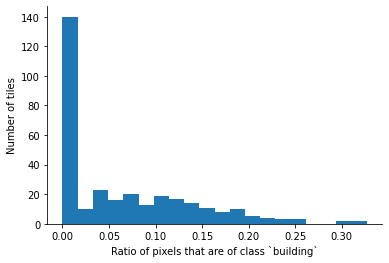

Mean Percentage of Pixels Belonging to Buildings: 0.064


In [16]:
# create dataloader to check building pixels
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y,
                                              bs = 64, codes = codes, seed = 2)

targs = torch.zeros((0, 512, 512))
for _, masks in dls[0]:
  targs = torch.cat((targs, masks.cpu()), dim = 0)

total_pixels = targs.shape[1]**2
percentages = torch.count_nonzero(targs, dim = (1,2)) / total_pixels
plt.hist(percentages, bins = 20)
plt.ylabel('Number of tiles')
plt.xlabel('Ratio of pixels that are of class `building`')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.show()
print(f"Mean Percentage of Pixels Belonging to Buildings: {round(percentages.mean().item(), 3)}")

The dataset is highly imbalanced: on average, only 6.4 % of the pixels in one of the tiles belongs to the building class.

## 3. Model Training

### 3.1. U-Net

#### 3.1.1. Image Augmentation

In [17]:
# Create image augmentations
tfms = [*aug_transforms(mult = 1.0, do_flip = True, flip_vert = False, max_rotate = 10.0,
                        min_zoom = 1.0, max_zoom = 1.1, max_warp = 0.2),
        Normalize.from_stats(*imagenet_stats)]

#### 3.1.2. Set Model Parameters and Create Model

In [19]:
# Set model, backbone, loss function and additional information for later comparison
architecture = "U-Net"
backbone = "resnet18" # Available architectures:
                        # resnet18, resnet34, resnet50, resnet101, resnet152
                        # squeezenet1_0, squeezenet1_1
                        # densenet121, densenet169, densenet201, densenet161
                        # vgg16_bn, vgg19_bn
                        # alexnet

loss_function = "CrossEntropyLoss" # Default: CrossEntropyLoss
                                    # FocalLoss, DiceLoss, Dual_Focal_loss, ...

fit_type = "FOC tfms" # FOC: fit_one_cycle, FT: fine_tune

# Use function to automatically set batch size depending on image size and architecture used
bs = batch_size(backbone, tile_size)

# Create function to load images and masks
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y,
                                              bs = bs, 
                                              codes = codes, seed = 2, # Use seed for reproducibility
                                              batch_tfms = tfms)
  
# Create model
learn = unet_learner(dls, resnet18, n_out = 2,
                     # optional: loss_func = Dual_Focal_loss(), # CombinedLoss(), DiceLoss(), FocalLoss(), ...
                     metrics = [Dice()] # Dice coefficient since dataset is imbalanced
                     ).to_fp16() # 16-bits floats, which take half the space in RAM

# Set path to model directory to store model and callbacks
model_dir = f"{path}/models/Ferris" # Change name
create_missing_folder(model_dir)

# Set callbacks (log results in CSV, show progress, and stop early if dice coefficient doesn't improve for 10 epochs)
cbs = [CSVLogger(fname = f"{model_dir}/{architecture}_{backbone}_{loss_function}_{fit_type}_{timestamp()}.csv", append = True),
       ShowGraphCallback(),
       EarlyStoppingCallback(monitor = 'dice', patience = 10, reset_on_fit = True)]
      # optional: SaveModelCallback(monitor = 'dice', fname = f"{model_dir}/{training_info}", at_end = True, with_opt = False, reset_on_fit = True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#### 3.1.3. Optional: U-Net with Weighted Cross Entropy Loss Function

In [ ]:
weights = [(1-percentages.mean().item()), percentages.mean().item()]
class_weights = torch.FloatTensor(weights).cuda()
learn.crit = nn.CrossEntropyLoss(weight = class_weights)

#### 3.1.4. Optional: Find Optimal Learning Rate

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


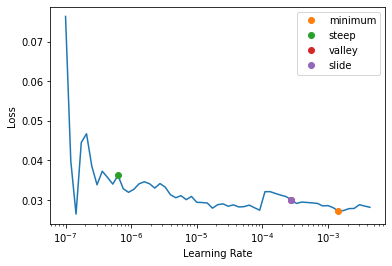

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

#### 3.1.2. Fitting the Model (One Cycle)

epoch,train_loss,valid_loss,dice,time
0,0.210654,0.099161,0.593479,01:02
1,0.127761,0.078168,0.788672,00:42
2,0.089537,0.051774,0.850041,00:42
3,0.070854,0.046955,0.863909,00:42
4,0.058788,0.041925,0.875021,00:42
5,0.051830,0.043420,0.858819,00:42
6,0.048729,0.037929,0.886057,00:42
7,0.045902,0.052062,0.854891,00:42
8,0.041767,0.035000,0.894668,00:42
9,0.041404,0.045239,0.842455,00:42


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


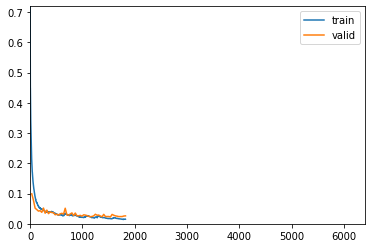

No improvement since epoch 47: early stopping


In [6]:
learn.fit_one_cycle(200, cbs = cbs)
model_notification()

In [24]:
learn.export(f'{model_dir}/{architecture}_{backbone}_{loss_function}_{fit_type}_{timestamp()}_exported')
learn.recorder.plot_loss()

In [2]:
# Alternative method to use transfer learning on pretrained model
learn.fine_tune(200, cbs = cbs)

In [ ]:
# Using one cycle training with a discriminative learning rate
learn.fit_one_cycle(100, slice(4e-7, lr_valley), cbs = cbs)

In [10]:
# Saving trained model
model_save_path = f"{model_dir}/{architecture}_{backbone}_{loss_function}_{fit_type}_{timestamp()}_saved_model"
learn.save(model_save_path, with_opt = True, pickle_protocol = 2)

Path('/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/U-Net_resnet18_CrossEntropyLoss_FOC tfms_2022-01-24_14:26_saved_model.pth')

In [22]:
learn.load('/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/U-Net_resnet18_CrossEntropyLoss_FOC tfms_2022-01-24_14:26_saved_model')

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


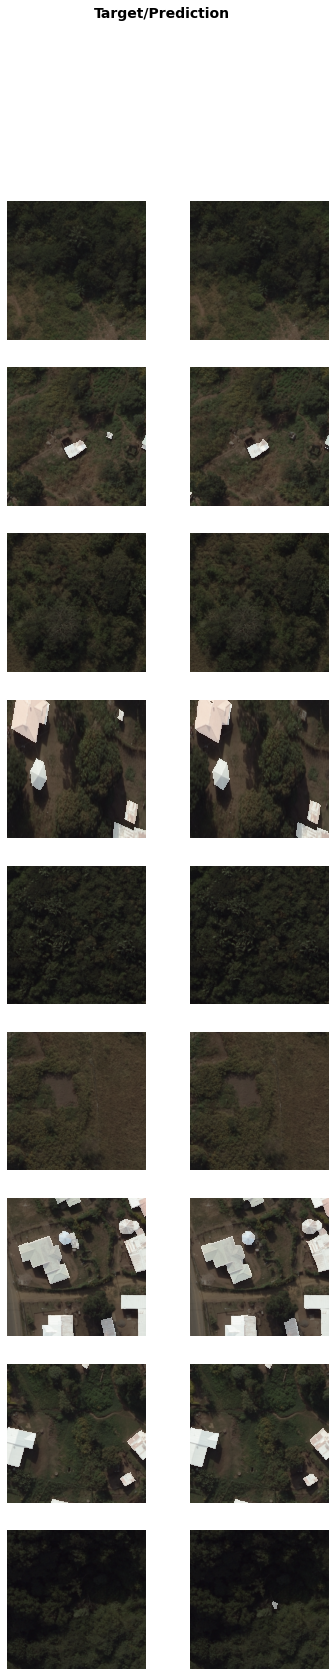

In [25]:
# Compare Target with Prediction
learn.show_results(cmap = 'hot', vmin = 0, vmax = 1)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


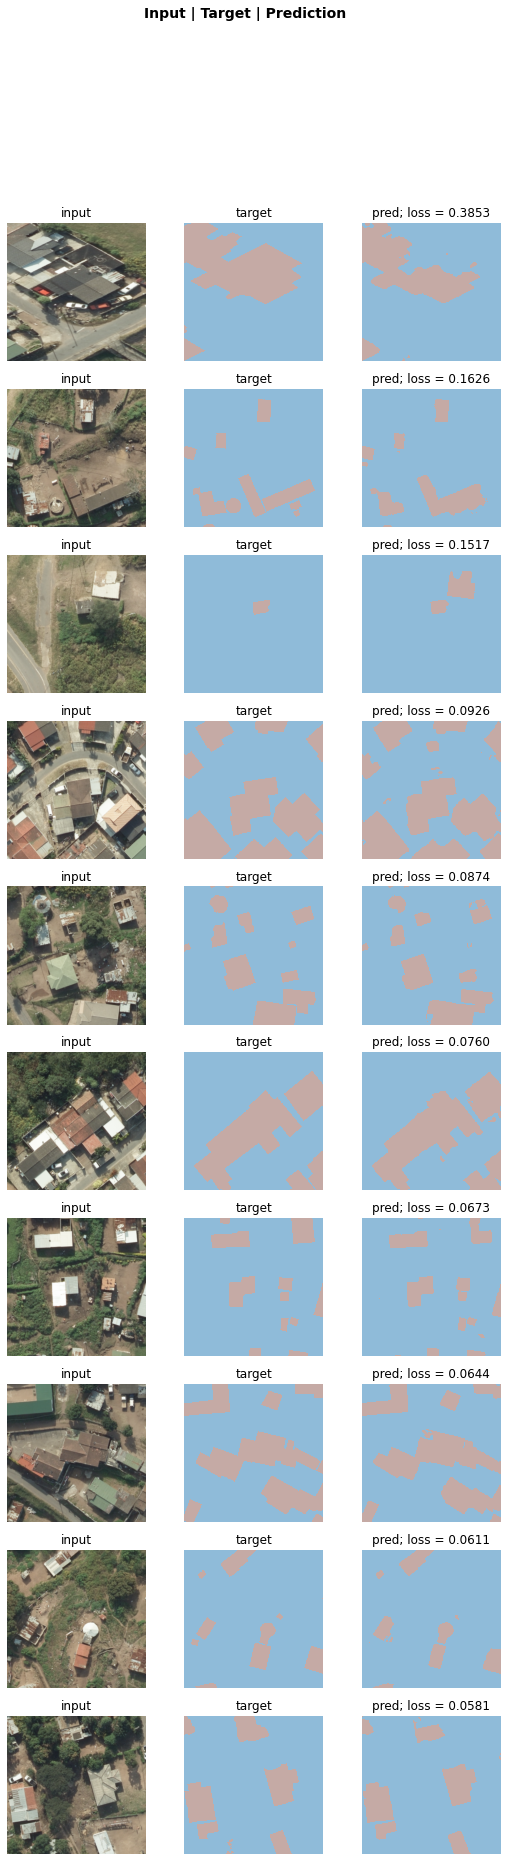

In [26]:
# Sort the model's errors on the validation set using the SegmentationInterpretation class and then plot the instances with the k highest contributions to the validation loss.
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k = 10)

### 3.2. HRNET

#### 3.2.1. Set Seed and Image Augmentation

In [ ]:
# Create Seed for Reproducibility
number_of_the_seed = 2022

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Augment Images
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline = Compose([Flip(p=0.5), Transpose(p=0.5), Rotate(p = 0.40, limit = 10)], p = 1)
transformPipeline = SegmentationAlbumentationsTransform(transformPipeline)

dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y,
                                              bs = 16,
                                              codes = codes, seed = 2022,
                                              item_tfms = transformPipeline,
                                              batch_tfms = [Normalize.from_stats(*imagenet_stats)])

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


#### 3.2.2. Train Models with Different Weight Decays

In [ ]:
wds = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for wd in wds:

  # Set date, loss function and name of model for CSV Logger and model saver
  architecture = "HRNET"
  loss_function = "Default Loss"
  fit_type = f"FOC 100 wd {wd}" # fit function epochs all-epochs frozen
  model_dir = f"{path}/models/Ferris"
  create_missing_folder(model_dir)

  cbs = [CSVLogger(fname = f"{model_dir}/{architecture}/{loss_function}/{fit_type}_{timestamp()}.csv", append = True),
         ShowGraphCallback(),
         EarlyStoppingCallback(monitor = 'dice', patience = 10, reset_on_fit = True)]

  learn = get_segmentation_learner(dls, number_classes = 2, segmentation_type = "Semantic Segmentation",
                                  architecture_name = "hrnet", backbone_name = "hrnet_w48", 
                                  model_dir = model_dir,
                                  metrics = [Dice()],
                                  wd = wd,
                                  splitter = trainable_params,
                                  pretrained = True).to_fp16()

  learn.fit_one_cycle(200, cbs = cbs)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
training_info = f"FOC 10 slice(1e-7, 1e-4) wd 1e-3"
model_dir = f"{path}/models/Ferris/{architecture}/{loss_function}/{timestamp()}_{training_info}"
create_missing_folder(model_dir)

cbs = [CSVLogger(fname = f"{model_dir}/{training_info}.csv", append = True),
       ShowGraphCallback(),
       EarlyStoppingCallback(monitor = 'dice', patience = 5, reset_on_fit = True)]

learn.fit_one_cycle(10, slice(1e-7, 1e-4), cbs = cbs)

### 3.3. Other Models (WIP)

#### 3.3.1. DeepLabV3

In [ ]:
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y,
                                                bs = 10, # If CUDA error, lower bs and go to Runtime -> Restart runtime
                                                codes = codes, valid_pct = 0.2, seed = 2)

deeplabv3_backbones = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "resnet50c", "resnet101c", "resnet152c", "xception65", "mobilenet_v2"]
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

architecture = "Deeplabv3" # Change this to your architecture
loss_function = "Default Loss" # Change this to loss function you want to use

for backbone in deeplabv3_backbones:
# Set date, loss function and name of model for CSV Logger and model saver
  training_info = f"FOC 200 {backbone}" # fit function epochs all-epochs frozen
  model_dir = f"{path}/models/Ferris/{architecture}/{loss_function}/{timestamp()}_{training_info}" # Change name
  create_missing_folder(model_dir)

# Create callbacks
  cbs = [CSVLogger(fname = f"{model_dir}/{training_info}.csv", append = True),
         ShowGraphCallback(),
         EarlyStoppingCallback(monitor = 'dice', patience = 10, reset_on_fit = True)]

  learn = get_segmentation_learner(dls = dls, number_classes = 2, segmentation_type = "Semantic Segmentation",
                                 architecture_name = "deeplabv3+", backbone_name = backbone, 
                                 metrics=[Dice()], wd = 1e-1,
                                 splitter=segmentron_splitter).to_fp16()

 # learn.fit_one_cycle(200, cbs = cbs)

#### 3.3.2. MaskRCNN

In [ ]:
def maskrcnn_splitter(model):
    return [params(model.backbone), params(model.rpn), params(model.roi_heads)]

dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y,
                                                bs = 10, # If CUDA error, lower bs and go to Runtime -> Restart runtime
                                                codes = codes, valid_pct = 0.2, seed = 2)

architecture = "MaskRCNN" # Change this to your architecture
loss_function = "Default Loss" # Change this to loss function you want to use

# Set date, loss function and name of model for CSV Logger and model saver
training_info = f"FOC 200 resnet50" # fit function epochs all-epochs frozen
model_dir = f"{path}/models/Ferris/{architecture}/{loss_function}/{timestamp()}_{training_info}" # Change name
create_missing_folder(model_dir)

# Create callbacks
cbs = [CSVLogger(fname = f"{model_dir}/{training_info}.csv", append = True),
        ShowGraphCallback(),
        EarlyStoppingCallback(monitor = 'dice', patience = 10, reset_on_fit = True)]

learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                architecture_name="maskrcnn", backbone_name="resnet50", 
                                image_size=512, metrics=[Dice()], wd=1e-2,
                                splitter=maskrcnn_splitter)

# Just freezing backbone
learn.freeze_to(-2)
learn.fine_tune(10)